Fast Proportional Selection
===

[RETWEET]

Proportional selection -- or, roulette wheel selection -- comes up frequently when developing agent-based models. Based on the code I have read over the years, researchers tend to write proportional selection as either a linear walk or a bisecting search. I compare the two approaches, then introduce Lipowski and Lipowska's [stochastic acceptance algorithm](http://arxiv.org/abs/1109.3627). For most of our uses, I argue that their algorithm is a better choice. 

Preliminaries
---
I will only use Python's internal random module for random number generation. I include numpy and pandas convenience only when running demos. I import seaborne because it overrides some matplotlib defaults in a pretty way. 

In [2]:
import random
from bisect import bisect_left
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

A Proportional Selection Base Class
---
I am interested in testing how the different algorithms perform when *implemented* and *used*. Algorithmic analysis gives us asymptotic estimations. From these, we know which algorithm should be the fastest, in the limit. But, for trivial values of $n$, asymptotics can be misleading. $O(1)$ is not always faster than $O(n)$. $O(1)$ is really $O(c)$, and $c$ can be very costly!

I use a base class, `ProportionalSelection`, to generate an equal playing field. This class takes the size of the vector of frequencies representing a distribution. I use frequencies because they are more natural to think about, and are easier to update. The client calls the `normalize` method any time the underlying frequencies change. Call the object like a dictionary to update a frequency.

In [3]:
class PropSelection(object):
    def __init__(self, n):
        self._n = n
        self._frequencies = [0] * n
    
    def copy_from(self, values):
        assert len(values) == self._n
        for i, x in enumerate(values):
            self[i] = x
            
    def __getitem__(self, i):
        return self._frequencies[i]
    
    def normalize(self):
        pass

Linear Walk
---
Sampling via linear walk is $O(n)$. The algorithm generates a random number between 0 and the sum of the frequencies. Then, it walks through the array of frequencies, producing a running total. At some point the running total exceeds the generated threshold. The index at that point is the selection. 

The algorithm has no cost associated with updates to the underlying frequency distribution. 

In [4]:
class LinearWalk(PropSelection):
    def __init__(self, n):
        super(LinearWalk, self).__init__(n)
        self._total = 0
    
    def __setitem__(self, i, x):
        self._total += (x - self._frequencies[i])
        self._frequencies[i] = x
        
    def sample(self):
        terminal_cdf_point = random.randint(0, self._total - 1)
        accumulator = 0
        for i, k in enumerate(self._frequencies):
            accumulator += k
            if accumulator > terminal_cdf_point:
                return i

Bisecting Search
---
Sampling via bisecting search is $O(log~n)$. From an asymptotic perspective, this is better than a linear walk. However, the algorithm achieves this by spending some compute time up front. That is, before sampling occurs. It cannot sample directly over the frequency distribution. Instead, it transforms the frequencies into a cumulative density function (CDF). This is an $O(n)$ operation. It must occur every time an element in the frequency distribution changes. 

Given the CDF, the algorithm draws a random number from [0, 1). It then uses bisection to identify the insertion point in the CDF for this number. This point is the selected index.

In [5]:
class BisectingSearch(PropSelection):
    def __init__(self, n):
        super(BisectingSearch, self).__init__(n)
        self._cdf = None
        self._total = 0
    
    def __setitem__(self, i, x):
        self._total += (x - self._frequencies[i])
        self._frequencies[i] = x
        
    def normalize(self):
        total = float(sum(self._frequencies))
        cdf = []
        accumulator = 0.0
        for x in self._frequencies:
            accumulator += (x / float(total))
            cdf.append(accumulator)
        self._cdf = cdf
        
    def sample(self):
        return bisect_left(self._cdf, random.random())

Stochastic Acceptance
---
For sampling, stochastic acceptance is $O(1)$. With respect to time, this dominates both the linear walk and bisecting search methods. Yet, this is asymptotic. The algorithm generates many random numbers per selection. In fact, the number of random variates grows in proportion to $n$. So, the random number generator matters. 

This algorithm has another advantage. It can operate on the raw frequency distribution, like linear walk. It only needs to track the maximum value in the frequency distribution. 

In [6]:
class StochasticAcceptance(PropSelection):
    def __init__(self, n):
        super(StochasticAcceptance, self).__init__(n)
        self._max_value = 0
    
    def __setitem__(self, i, x):
        last_x = self._frequencies[i]
        
        if x > self._max_value:
            self._max_value = float(x)
        elif last_x == self._max_value and x < last_x:
            self._max_value = float(max(self._frequencies))
            
        self._frequencies[i] = x
        
    def sample(self):
        n = self._n
        max_value = self._max_value
        freqs = self._frequencies
        
        while True:
            i = int(n * random.random())
            if random.random() < freqs[i] / max_value:
                return i

First Demonstration: Sampling
---
The following code generates a target frequency distribution. Then, it instantiates each algorithm; copies the frequency distribution; and, draws 10,000 samples. For each algorithm, this code compiles the resulting probability distribution. For comparison, I plot these side by side. In the figure below, the target distribution is to the left (green). The linear walk, bisecting search, and stochastic acceptance algorithms are to the right of the targert distribution (blue). 

Visually, there is a compelling case for the distributions being equal.

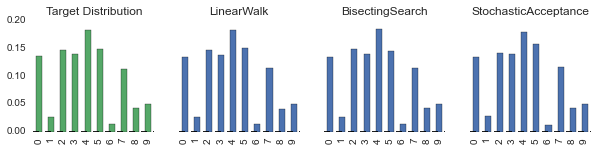

In [17]:
fig, ax = plt.subplots(1, 4, sharey=True, figsize=(10,2))

def plot_proportions(xs, ax, **kwargs):
    xs = pd.Series(xs)
    xs /= xs.sum()
    return xs.plot(kind='bar', ax=ax, **kwargs)

def sample_and_plot(roulette_algo, ax, n_samples=10000, **kwargs):
    samples = [roulette_algo.sample() for _ in range(n_samples)]
    value_counts = pd.Series(samples).value_counts().sort_index()
    props = (value_counts / value_counts.sum())
    props.plot(kind='bar', ax=ax, **kwargs)
    return samples

freqs = np.random.randint(1, 100, 10)
plot_proportions(freqs, 
                 ax[0], 
                 color=sns.color_palette()[1],
                 title="Target Distribution")

klasses = [LinearWalk, BisectingSearch, StochasticAcceptance]
for i, klass in enumerate(klasses):
    algo = klass(len(freqs))
    algo.copy_from(freqs)
    algo.normalize()
    
    name = algo.__class__.__name__
    xs = sample_and_plot(algo, ax=plt.subplot(ax[i+1]), title=name)

Second Demonstration: Performance Testing
---
The following code times the sample method for each algorithm. I am using the `timeit` module's `default_timer` for timing. For such fast functions, this may lead to measurement error. But, over 10,000 samples, I expect these errors to wash out. 

In [35]:
import timeit

def sample_n_times(algo, n):
    samples = []
    for _ in range(n):
        start = timeit.default_timer()
        algo.sample()
        samples.append(timeit.default_timer() - start)
    return np.array(samples)


timings = []
for i, klass in enumerate(klasses):
    algo = klass(len(freqs))
    algo.copy_from(freqs)
    algo.normalize()
    
    name = algo.__class__.__name__
    
    timings.append((name, sample_n_times(algo, 10000)))

The graph immediately below plots the kernel density estimation of timings for each algorithm. I truncate the results, limiting the range to everything less than the 90th percentile. (I'll explain why momentarily.) Bisecting search appears to be the fastest and the most stable. This makes sense. It has nice worse-case properties. 

Stochastic acceptance and linear walk both display variability in timings. Again, the timer is not very precise. But, since bisecting search used the same timer, a comparison is possible. Linear walk has a worst case performance of $O(n)$. That is, if it starts at index 0 and generates the maximum value, it has to traverse the entire array. Bisecting search generates a stream of random numbers until finding an acceptable one. Technically, this algorithm has no limit. It could loop infinitely, waiting for a passing condition. But, probabilistically, this is fantastically unlikely. (Sometimes, you come across coders saying code like this is incorrect. That's pretty absurd. Most of the time, the probability of pathological conditions is so small, it's irrelevant. Most of the time, the machine running your code is more likely to crumb to dust before an error manifests.)

For real-time code, timing variability matters. Introduce some jitter into something like a HFT algorithm, and you lose. But, for agent-based models and offline machine learning, variability doesn't matter. For us, averages matter.  

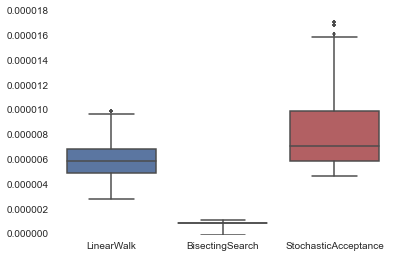

In [45]:
values = np.vstack([times for _, times in timings]).T
values = values[np.all(values < np.percentile(values, 90, axis=0), axis=1)]
sns.boxplot(values, names=[name for name, _ in timings]);

The relationship between algorithms remains the same. But, the difference between linear walk and stochastic acceptance grows. Over the entire distribution, stochastic acceptance lags both linear walk and bisecting search.

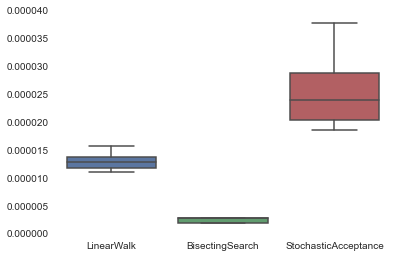

In [46]:
values = np.vstack([times for _, times in timings]).T
values = values[np.all(values > np.percentile(values, 90, axis=0), axis=1)]
sns.boxplot(values, names=[name for name, _ in timings]);

Third Demonstration: Average Time as a Function of N
---
The previous demonstrations fixed n to 10. What happens as n increases?

In [61]:
import timeit

def sample_n_times(algo, n):
    samples = []
    for _ in range(n):
        start = timeit.default_timer()
        algo.sample()
        samples.append(timeit.default_timer() - start)
    return np.array(samples)


averages = []
for n in [10, 100, 1000, 10000, 100000, 1000000]:
    row = {'n': n}
    freqs = np.random.randint(1, 100, n)
    for i, klass in enumerate(klasses):
        algo = klass(len(freqs))
        algo.copy_from(freqs)
        algo.normalize()

        name = algo.__class__.__name__
        row[name] = np.mean(sample_n_times(algo, 10000))
    averages.append(row)

The following graph plots the average time as a function of n, the number of elements in the distribution. There is nothing unexpected. Linear walk gets increasingly terrible. It's $O(n)$. Bisecting search out-performs Stochastic acceptance. They appear to be converging. But, this convergence occurs at the extreme end of n. Few simulations sample over a distribution of 1,000,00 values.  

At this point, it seems like bisecting search is the best choice.

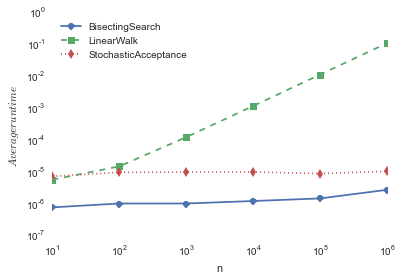

In [73]:
averages_df = pd.DataFrame(averages).set_index('n')
averages_df.plot(logy=True, logx=True, 
                 style={'BisectingSearch': 'o-',
                        'LinearWalk': 's--',
                        'StochasticAcceptance': 'd:'})#marker='o')
plt.ylabel('$Average runtime$');

Fourth Demonstration: Time Given a Dynamic Distribution
---
Many of my simulations use proportional selection with dynamic proportions. For example, consider preferential attachment in social network generation. Edges form probabilistically, proportional to a node's degree. But, when an edge forms, the degree changes as well. In this case, the distribution changes *for each sample*!

Below, I repeat the previous experiment, but I change the distribution and call `normalize` before each sample. Bisecting search is now the loser in this race. After each frequency alteration, it runs an expensive $O(n)$ operation. Then, it still must run its $O(log~n)$ operation at sample time. Linear walk and stochastic acceptance incur almost no performance penalty for alterations. Linear walk merely updates the total count. And, stochastic acceptance only runs a calculation if the alteration reduces the maximum value. (This hints at an important exception. As the range of frequencies narrows and the number of elements increases, performance suffers. The number of $O(n)$ searches for the new maximum becomes expensive.)

In [84]:
import timeit

def normalize_sample_n_times(algo, n_samples, n):
    samples = []
    for _ in range(n_samples):
        algo[random.randint(0, n-1)] = random.randint(1, 100)
        start = timeit.default_timer()
        algo.normalize()
        algo.sample()
        samples.append(timeit.default_timer() - start)
    return np.array(samples)


averages = []
for n in [10, 100, 1000, 10000, 100000]:
    row = {'n': n}
    freqs = np.random.randint(1, 100, n)
    for i, klass in enumerate(klasses):
        algo = klass(len(freqs))
        algo.copy_from(freqs)
        algo.normalize()

        name = algo.__class__.__name__
        row[name] = np.mean(normalize_sample_n_times(algo, 1000, n))
    averages.append(row)

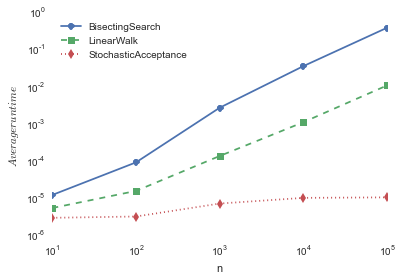

In [85]:
averages_df = pd.DataFrame(averages).set_index('n')
averages_df.plot(logy=True, logx=True, 
                 style={'BisectingSearch': 'o-',
                        'LinearWalk': 's--',
                        'StochasticAcceptance': 'd:'})#marker='o')
plt.ylabel('$Average runtime$');

Conclusions
---

"Premature optimization is the root of all evil." This is programmer's cannon -- The Gospel According to Knuth. Certainly, I'm not advocating for heresy. I wrote this post after a project of mine demanded better performance. Execution took too long. I did some profiling. It told me that proportional selection dominated execution time. So, partially, this notebook is a guide for modelers in similar situations. Given a dynamic distribution and proportional selection, stochastic acceptance has great performance. 

Outside of dynamic distributions, it does not dominate performance-wise in all cases. And, it is subject to jitter, making it questionable for real-time systems. But, it is robust across a variety of usage patterns. Furthermore, the algorithm is straight-forward to implement. The following code expresses it in it's simplest form. There are no dependencies, other than to a random number generator. And random number generation is a universal facility in programming languages. 

```python
def random_proportional_selection(freqs, max_freq):
    n = len(freqs)
    
    while True:
        i = int(n * random.random())
        if random.random() < (freqs[i] / float(max_freq)):
            return i
```

Given these properties, I think it makes a good default approach to proportional selection. And, rewards accrue to those who collect good defaults.

